# Problem 6: Regression techniques

In this problem we use the same data set on service usage of 1000 clients of a telecommunication company as in Assignment 2.. The long distance calls longmon is taken as the dependent variable and the remaining variables as explanatory.

In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import scipy.stats as stats
import statsmodels.api as sm
from sklearn import linear_model, metrics
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
sns.set_style("darkgrid")
import warnings
warnings.filterwarnings('ignore')
from utils import *

df_raw = pd.read_csv('data/telco.txt', sep='\t')
N = len(df_raw)

# Group variables by the type of the scale
intervals = list(df_raw.dtypes[(df_raw.dtypes == np.int64) | 
                               (df_raw.dtypes == np.float64)].index)    
ordinals = ['ed']
nominals = list(set(df_raw.dtypes.index).difference(intervals, ordinals))

ed_dummies = pd.get_dummies(df_raw.ed)
ed_names_dict = {'College degree': 'ed_college',
                 'Did not complete high school': 'ed_no',
                 'High school degree': 'ed_highschool',
                 'Post-undergraduate degree': 'ed_postgr',
                 'Some college': 'ed_somecollege'}
ed_dummies = ed_dummies.rename(columns=ed_names_dict).drop(['ed_no'], 1)
ed_dummies.head()
df_dummies = pd.concat((df_raw.drop('ed', 1), ed_dummies), 1)
df_dummies['marital'] = df_dummies.marital.map(dict(Married=1, Unmarried=0))
df_dummies['retire'] = df_dummies.retire.map(dict(Yes=1, No=0))
df_dummies['gender'] = df_dummies.gender.map(dict(Female=1, Male=0))
df_dummies['churn'] = df_dummies.churn.map(dict(Yes=1, No=0))
df_dummies.head()
df = df_dummies.copy()

df['log_longmon'] = np.log(df['longmon'])
df['log_income'] = np.log(df['income'])
df['wire_not_used'] = (df['wiremon']==0).astype(np.int)

regressand = 'log_longmon'
regressors = sorted(list(set(df.columns)\
             .difference({'longmon', 'log_longmon', 'income', 'wiremon'})))
intervals_regressors = sorted(list(set(intervals).union({'log_income'})\
                       .difference({'longmon', 'income', 'wiremon'})))
other_regressors = sorted(list(set(regressors)\
                   .difference(intervals_regressors)))

X, y = get_X_y(df, regressand, regressors)
K = X.shape[1]

Explained: log_longmon
Explanatory: ['address', 'age', 'churn', 'ed_college', 'ed_highschool', 'ed_postgr', 'ed_somecollege', 'employ', 'gender', 'log_income', 'marital', 'retire', 'tenure', 'wire_not_used']


### 1. The lasso regression is an alternative approach to variable selection.

(a) Explain in your own words the idea of the lasso regression. Sketch a situation when a simple linear regression fails, but the lasso regression still can be estimated.

> Lasso regression is another way to select variables thanks to the regularization term in the objective function. More precisely, we minimize the sum of squared residuals plus the sum of absolute values of all coefficients (or L1-norm) with a multiplier, which is equivalent to the constrained optimization. As in the case of L2-regularization, we constraint the coefficients, thus preventing it from blowing in absolute values. This additional constraint lets us get estimation even having correlated regressors whereas a simple linear regression would fail there. And because of the contour form obtained from the constraint (the figure consists of linear parts), it intersects an objective funtion in a point that more likely has zero-coordinates than in L2-regularization, filtering variables this way.

(b) For the usual regression model the variables are rarely normalized/standardized. However, in the case of the lasso regression the scaling becomes crucial. Why? Scale your data by $((x_i − \overline x) / \hat\sigma_x)$. Can/should the binary variables be scaled in the same fashion? How would you handle the variable ed?

> The lasso method requires initial standardization of the regressors, so that the penalization scheme is fair to all regressors; dummy variables should also be standardized.

Number of observations: 1000


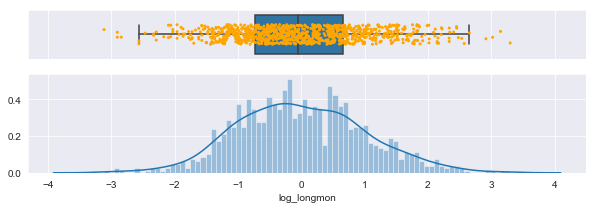

Variable `address`
Number of observations: 1000


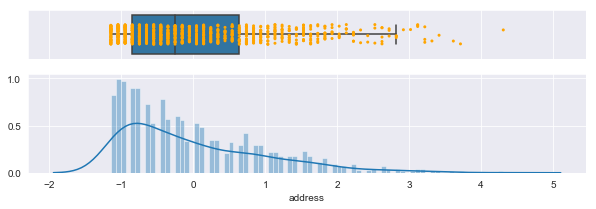

Variable `age`
Number of observations: 1000


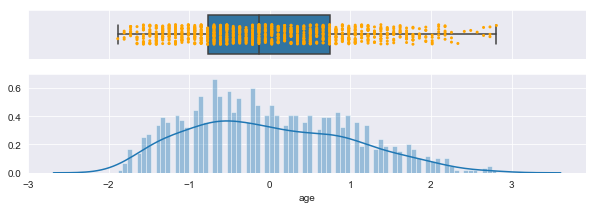

Variable `churn`
Number of observations: 1000


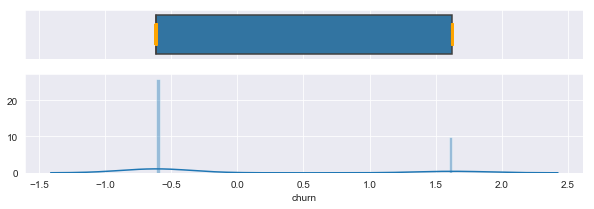

Variable `ed_college`
Number of observations: 1000


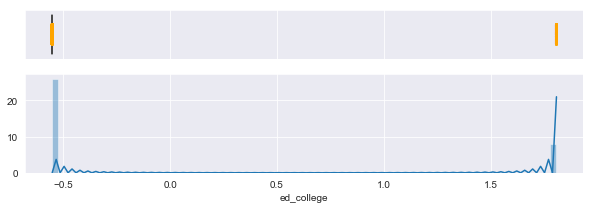

Variable `ed_highschool`
Number of observations: 1000


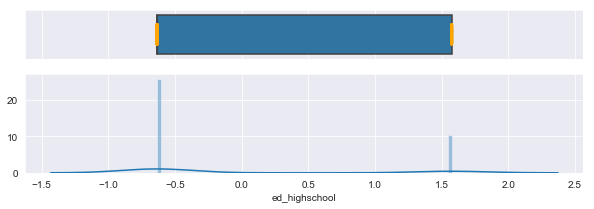

Variable `ed_postgr`
Number of observations: 1000


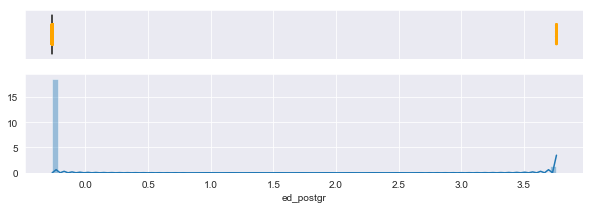

Variable `ed_somecollege`
Number of observations: 1000


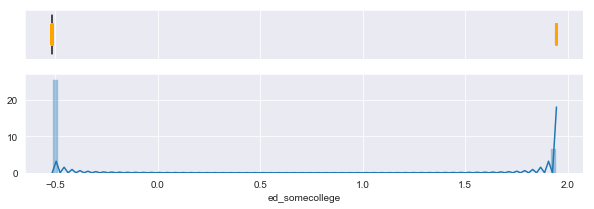

Variable `employ`
Number of observations: 1000


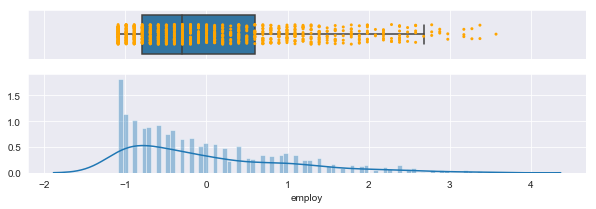

Variable `gender`
Number of observations: 1000


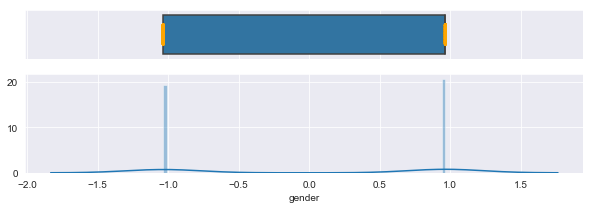

Variable `log_income`
Number of observations: 1000


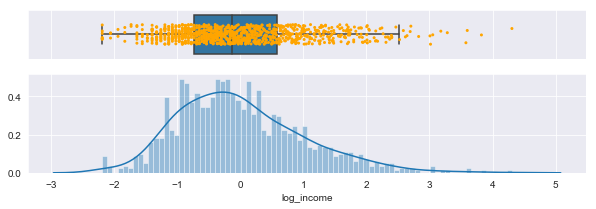

Variable `marital`
Number of observations: 1000


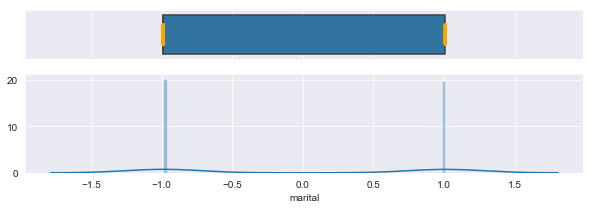

Variable `retire`
Number of observations: 1000


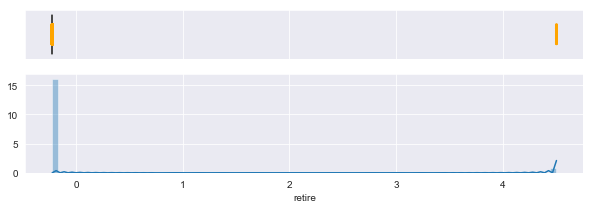

Variable `tenure`
Number of observations: 1000


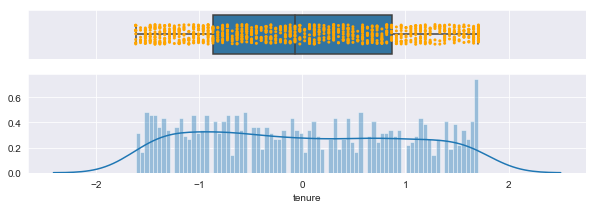

Variable `wire_not_used`
Number of observations: 1000


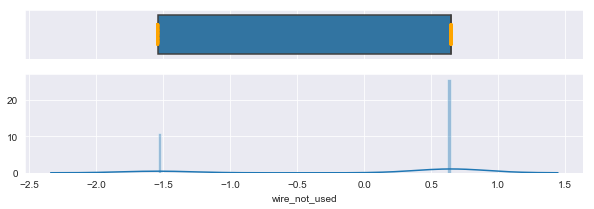

In [2]:
X, y, X_intervals_means, X_intervals_stds, y_mean, y_std = \
                            get_normalized_X_y(X, y, regressors)
represent_distribution(y)
for c in X:
    represent_distribution(X[c], varname=c)

(c) Run a lasso regression for data with $\alpha \in (0,1)$. Plot the estimated parameters as functions of $\alpha$. Which value of $\alpha$ would you recommend? If easy to implement determine the optimal $\alpha$ by cross-validation.

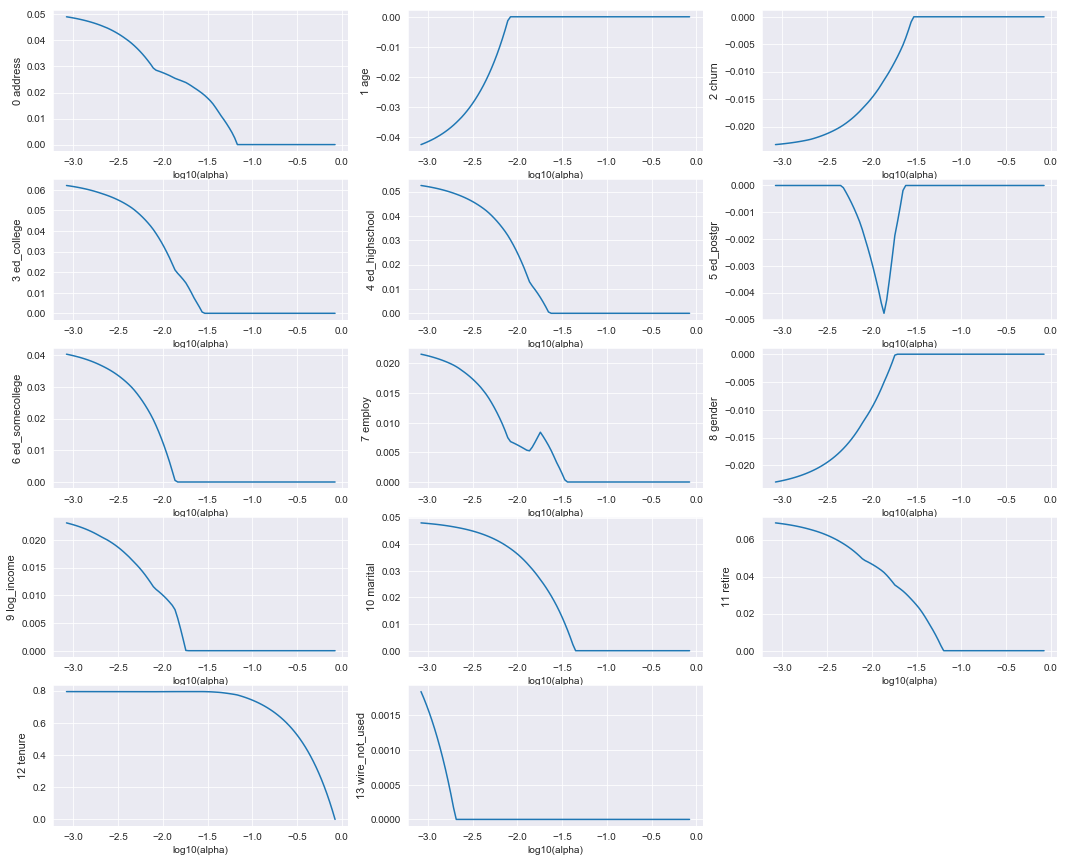

In [3]:
from sklearn.linear_model import LassoCV
mpl.rcParams['figure.figsize'] = (18, 15)

cv_k = 10
LassoReg = LassoCV(cv=cv_k, random_state=0)
LassoReg.fit(X, y)
alphas, coefs = LassoReg.path(X, y)[:2]
plt.title('Estimated parameters')
for i, c in enumerate(coefs):
    plt.subplot(5,3,i+1)
    plt.ylabel(str(i)+' '+X.columns[i], fontsize=11)
    plt.xlabel('log10(alpha)')
    plt.plot(np.log10(alphas), c)
plt.show()

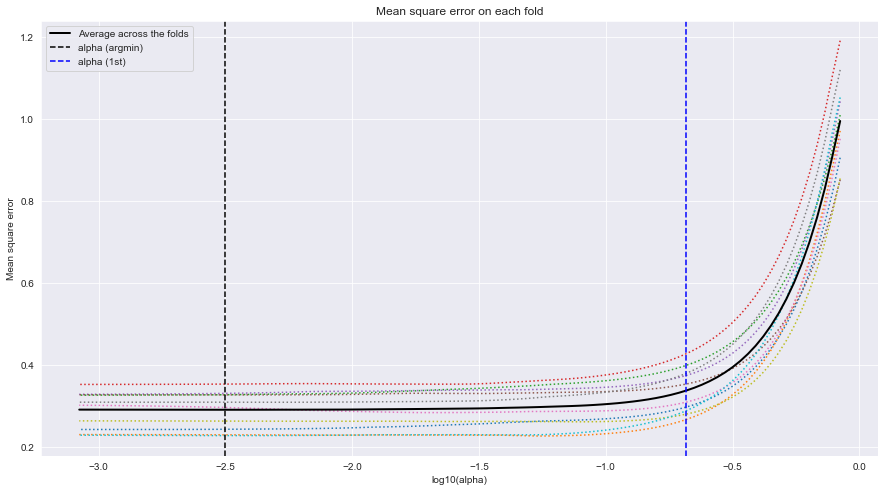

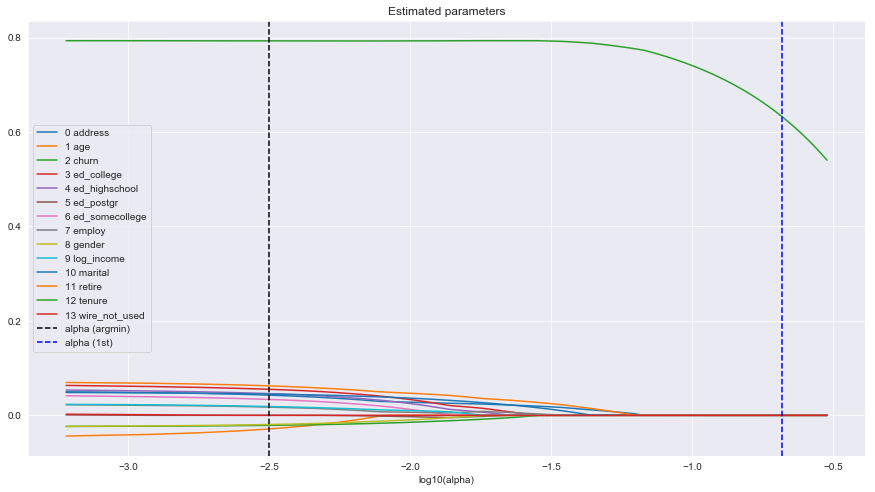

In [4]:
mpl.rcParams['figure.figsize'] = (15, 8)
alpha = LassoReg.alpha_
mean = LassoReg.mse_path_[np.where(LassoReg.alphas_ == LassoReg.alpha_)].mean()
sigma = LassoReg.mse_path_[np.where(LassoReg.alphas_ == LassoReg.alpha_)].std(ddof=1)
ind1 = np.argmin(np.abs(LassoReg.mse_path_.mean(axis=-1) - (mean+sigma)))
alpha1 = LassoReg.alphas_[ind1]

m_log_alphas = np.log10(LassoReg.alphas_)

plt.figure()
plt.plot(m_log_alphas, LassoReg.mse_path_, ':')
plt.plot(m_log_alphas, LassoReg.mse_path_.mean(axis=-1), 'k',
         label='Average across the folds', linewidth=2)
plt.axvline(np.log10(alpha), linestyle='--', color='k', label='alpha (argmin)')
plt.axvline(np.log10(alpha1), linestyle='--', color='b', label='alpha (1st)')

plt.legend()  

plt.xlabel('log10(alpha)')
plt.ylabel('Mean square error')
plt.title('Mean square error on each fold')
plt.axis('tight')
plt.show()

alphas, coefs = LassoReg.path(X, y, alphas=np.linspace(0,0.3,500))[:2]
I = np.arange(14)
for i, c in zip(I, coefs[I]):
    plt.plot(np.log10(alphas), c, label=str(i)+' '+X.columns[i])
plt.axvline(np.log10(alpha), linestyle='--', color='k', label='alpha (argmin)')
plt.axvline(np.log10(alpha1), linestyle='--', color='b', label='alpha (1st)')
plt.xlabel('log10(alpha)')
plt.legend()
plt.title('Estimated parameters')
plt.show()

In [5]:
print('The best in terms of {}-fold CV (argmin MSE) alpha = {:.4f}'.format(cv_k, LassoReg.alpha_))
print('Estimated parameters:\n', pd.DataFrame(LassoReg.coef_, X.columns, columns=['coef']))
print('\nThe first alpha = {:.4f}'.format(alpha1))
print('Estimated parameters:\n', pd.DataFrame(coefs[:,ind1], X.columns, columns=['coef']))

The best in terms of 10-fold CV (argmin MSE) alpha = 0.0032
Estimated parameters:
                     coef
address         0.042659
age            -0.028742
churn          -0.021326
ed_college      0.055013
ed_highschool   0.045919
ed_postgr      -0.000000
ed_somecollege  0.033611
employ          0.017178
gender         -0.019488
log_income      0.018790
marital         0.044982
retire          0.062375
tenure          0.792897
wire_not_used   0.000000

The first alpha = 0.2080
Estimated parameters:
                     coef
address         0.000000
age             0.000000
churn          -0.000000
ed_college      0.000000
ed_highschool   0.000000
ed_postgr      -0.000000
ed_somecollege -0.000000
employ          0.000000
gender         -0.000000
log_income      0.000000
marital         0.000000
retire          0.000000
tenure          0.552167
wire_not_used  -0.000000


> The minimum of MSE is achieved with $\alpha = 0.0032$. $\alpha_{1st} = 0.2080$, but we see that it throws out all except one regressor `tenure`.

### 2. A nonlinear regression oﬀers a ﬂexible technique for modelling complex relationships.

We wish to explain the longmon by the years under the current address of the clients.

(a) Make a bivariate scatter plot and estimate an appropriate linear (!) model. Add the regression curve to the plot.

Explained: longmon
Explanatory: ['address']
Result:
  Intercept	6.197
  Slope		0.48


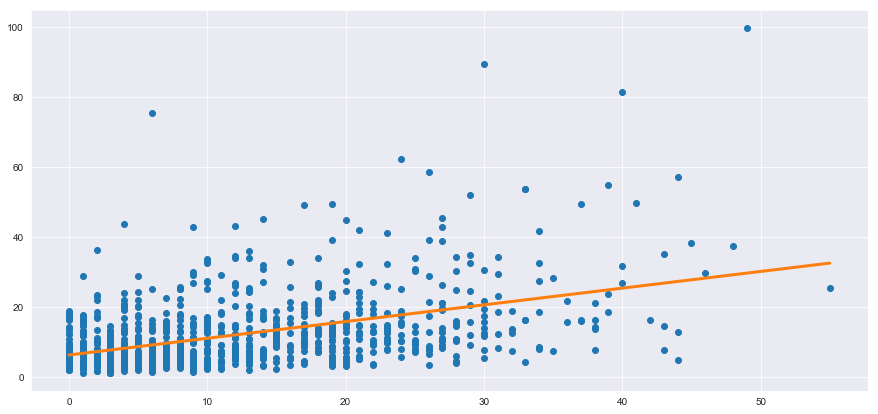

In [6]:
from sklearn.linear_model import LinearRegression
mpl.rcParams['figure.figsize'] = (15, 7)

x, y = get_X_y(df, 'longmon', ['address'])
t = np.linspace(x.min(), x.max(), 500)

plt.scatter(x.address, y)
OLS = LinearRegression(fit_intercept=True).fit(x, y)
print('Result:\n  Intercept\t{:.3f}\n  Slope\t\t{:.2f}'.format(OLS.intercept_, OLS.coef_[0]))
plt.plot(t, OLS.predict(t), c='C1', linewidth=3)
plt.show()

(b) Estimate now an appropriate nonlinear regression which might ﬁt the data better. Add the regression curve to the plot and compare (quantitatively) the ﬁt with the ﬁt of the linear model.

eq_nls: y ~ beta_1 + beta_2 * np.exp(beta_3 * x)

[[Model]]
    Model(eq_nls)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 166
    # data points      = 1000
    # variables        = 3
    chi-square         = 83034.2265
    reduced chi-square = 83.2840788
    Akaike info crit   = 4425.25289
    Bayesian info crit = 4439.97616
[[Variables]]
    a: -2.09670374 +/- 4.37623342 (208.72%) (init = 1)
    b:  9.36267760 +/- 4.01762760 (42.91%) (init = 1)
    c:  0.02945395 +/- 0.00760664 (25.83%) (init = 0.5)
[[Correlations]] (unreported correlations are < 0.100)
    C(a, b) = -0.997
    C(b, c) = -0.991
    C(a, c) =  0.981



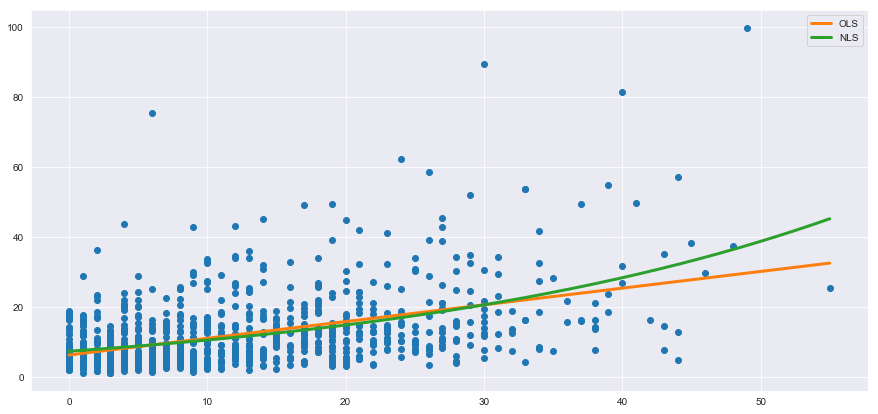

R^2 for OLS Regression: 0.217
R^2 for NLS Regression: 0.226


In [7]:
from sklearn.metrics import r2_score
import lmfit

print('eq_nls: y ~ beta_1 + beta_2 * np.exp(beta_3 * x)\n')
def eq_nls(x, a, b, c):
    return a + b * np.exp(c * x)

NLS = lmfit.Model(eq_nls)
lm_result = NLS.fit(y, x=x.address, a=1.0, b=1.0, c=0.5)
print(lm_result.fit_report())

params = [v.value for v in lm_result.params.values()]

plt.scatter(x.address, y, label=None)
plt.plot(t, OLS.predict(t), c='C1', linewidth=3, label='OLS')
plt.plot(t, eq_nls(t, *params), c='C2', linewidth=3, label='NLS')
plt.legend()
plt.show()

ols_y_pred = OLS.predict(x)
nls_y_pred = eq_nls(x, *params)
print("R^2 for OLS Regression: {:.3f}".format(r2_score(y, ols_y_pred)))
print("R^2 for NLS Regression: {:.3f}".format(r2_score(y, nls_y_pred)))

> NLS gives more accurate fit.

(c) Explain in your own words, why all the classical tests and inferences are not directly applicable to the NLS estimators.

> Because NLS parameter estimators are not linear functions of residuals, they are not normally distributed (only asymptotically), and the assumption for the classical tests and inferences is violated.

### 3. Next we model the relationship between longmon and address using the nonparametric Nadaraya-Watson regression.

In [8]:
from statsmodels.nonparametric.kernel_regression import KernelReg

(a) An important calibration parameter of a nonparametric regression is the bandwidth. Explain what happens with the regression/the weights in the NadarayaWatson regression if the bandwidth is too high or too small.

> The bandwidth acts as a smoothing parameter: if it is set too small, the result is a very noisy model (see first figure), whereas if it is set too large, then the result is very rough (smoothed, see second figure).

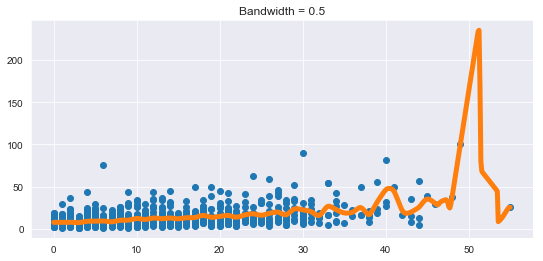

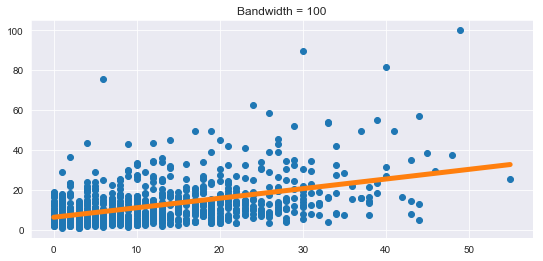

In [9]:
mpl.rcParams['figure.figsize'] = (9, 4)
for bw_setting in [[0.5], [100]]:
    kr = KernelReg(y, x, var_type='c', bw=bw_setting)
    m = kr.fit(t)[0]
    plt.scatter(x, y)
    plt.plot(t, m, c='C1', linewidth=5)
    plt.title('Bandwidth = {}'.format(bw_setting[0]))
    plt.show()

(b) Fit a Nadaraya-Watson regression with Gaussian kernel and “optimal” bandwidth to the longmon/address data. Check and explain how the “optimal bandwidth” is determined in your software. Plot the data and the regression curve.

In [10]:
bw_setting = 'cv_ls'
kr = KernelReg(y, x, var_type='c', bw=bw_setting)

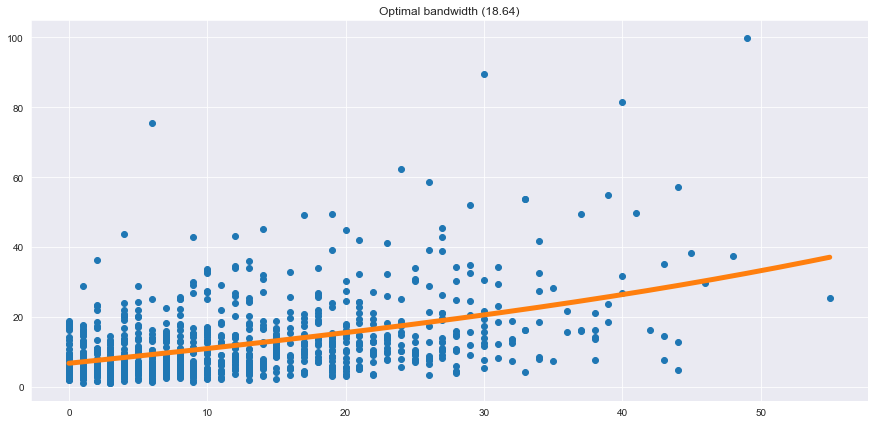

In [11]:
mpl.rcParams['figure.figsize'] = (15, 7)
t = np.linspace(x.min(), x.max(), 500)
m = kr.fit(t)[0]
plt.scatter(x, y)
plt.plot(t, m, c='C1', linewidth=5)
plt.title('Optimal bandwidth ({:.2f})'.format(kr.bw[0]))
plt.show()

> The optimal value of the bandwidth is calculated via minimizing the cross-validation least-squares function:
>
>\begin{equation}
C V(h)=n^{-1} \sum_{i=1}^{n}(Y_{i}-g_{-i}(X_{i}))^{2}
\end{equation}
>
>where $g_{-i}(X_{i})$ is the leave-one-out estimator of $g(X)$ and $h$ is the vector of bandwidths.

(c) Compare the (in-sample) ﬁt of the nonparametric regression and the nonlinear regression in the previous subproblem.

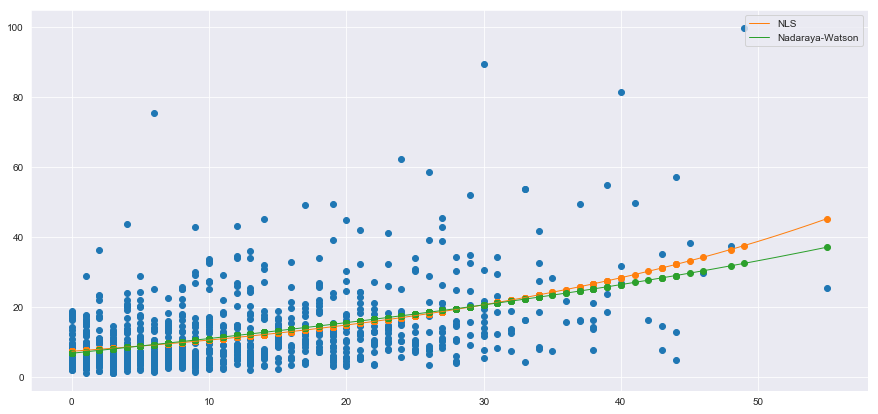

R^2 for NLS Regression: 0.226
R^2 for Nadaraya-Watson Regression: 0.222


In [16]:
kr_y_pred = kr.fit(x)[0]
nls_y_pred = eq_nls(x, *params)
plt.scatter(x, y)
plt.scatter(x, nls_y_pred)
plt.plot(t, eq_nls(t, *params), c='C1', linewidth=1)
plt.plot(t, m, c='C2', linewidth=1)
plt.legend(['NLS', 'Nadaraya-Watson'])
plt.scatter(x, kr_y_pred)
plt.show()

print("R^2 for NLS Regression: {:.3f}".format(r2_score(y, nls_y_pred)))
print("R^2 for Nadaraya-Watson Regression: {:.3f}".format(r2_score(y, kr_y_pred)))

> NLS still gives a bit more accurate fit.

### 4. Next we consider classiﬁcation of the clients using the churn variable as the dependent variable and the logistic regression.

(a) Fit a logistic regression to explain churn by the remaining explanatory variables.

In [17]:
regressand = 'churn'
regressors = sorted(list(set(df.columns).difference({'churn', 'longmon', 'income', 'wiremon'})))
intervals_regressors = sorted(list(set(intervals).union({'log_longmon', 'log_income'}).difference({'longmon', 'income', 'wiremon'})))
other_regressors = sorted(list(set(regressors).difference(intervals_regressors)))

X, y = get_X_y(df, regressand, regressors)

K = X.shape[1]

X, _, X_intervals_means, X_intervals_stds, _, _ = \
                            get_normalized_X_y(X, y, intervals_regressors)

X_ = sm.add_constant(X)
LogR = sm.Logit(y, X_).fit()
LogR.summary()

Explained: churn
Explanatory: ['address', 'age', 'ed_college', 'ed_highschool', 'ed_postgr', 'ed_somecollege', 'employ', 'gender', 'log_income', 'log_longmon', 'marital', 'retire', 'tenure', 'wire_not_used']
Optimization terminated successfully.
         Current function value: 0.480001
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  churn   No. Observations:                 1000
Model:                          Logit   Df Residuals:                      985
Method:                           MLE   Df Model:                           14
Date:                Tue, 07 May 2019   Pseudo R-squ.:                  0.1826
Time:                        12:00:01   Log-Likelihood:                -480.00
converged:                       True   LL-Null:                       -587.20
                                        LLR p-value:                 6.224e-38
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -1.4021      0.292     -4.796      0.000      -1.975      -0.829
address           -0.1608      0.129     -1.251      0.211      -0.413       0.091
age               -0.0030      0.138     -0.022      0.982      -0.274       0.268
ed_college         0.7414      0.283      2.616      0.009       0.186       1.297
ed_highschool      0.2204      0.267      0.826      0.409      -0.302       0.743
ed_postgr          0.8493      0.380      2.235      0.025       0.104       1.594
ed_somecollege     0.3899      0.279      1.397      0.162      -0.157       0.937
employ            -0.4406      0.172     -2.556      0.011      -0.778      -0.103
gender             0.0743      0.160      0.465      0.642      -0.239       0.388
log_income         0.1850      0.138      1.337      0.181      -0.086       0.456
log_longmon       -0.2590      0.151     -1.718      0.086      -0.554       0.036
marital            0.0644      0.164      0.392      0.695      -0.258       0.386
retire            -0.3038      0.736     -0.413      0.680      -1.746       1.138
tenure            -0.6295      0.158     -3.978      0.000      -0.940      -0.319
wire_not_used     -0.4971      0.177     -2.801      0.005      -0.845      -0.149
==================================================================================
"""

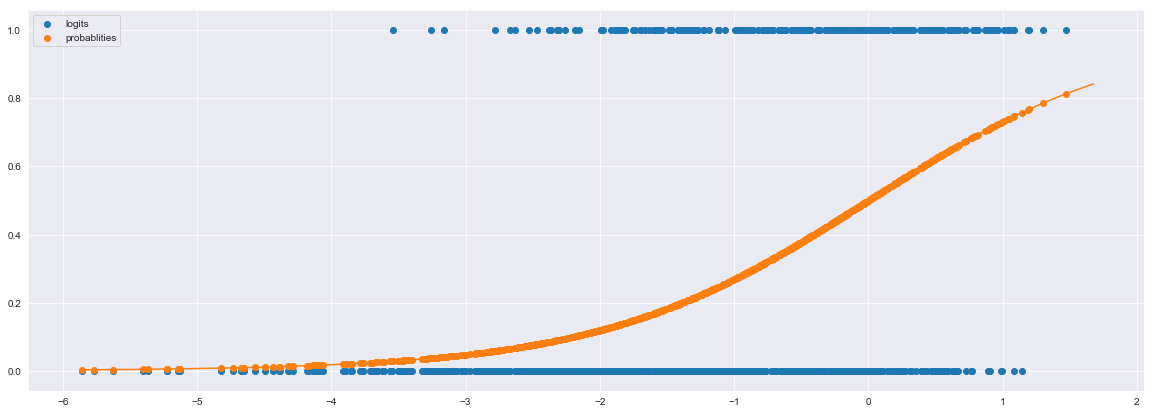

In [18]:
def visualize_LogR(LogR, X_, y):
    mpl.rcParams['figure.figsize'] = (20,7)
    logits = np.dot(X_, LogR.params)
    probs = LogR.predict(X_)
    t = np.linspace(logits.min(), logits.max()+0.2, 500)
    plt.scatter(logits, y)
    plt.scatter(logits, probs)
    plt.legend(['logits', 'probablities'])
    plt.plot(t, 1/(1 + np.exp(-t)), 'C1')
    plt.show()
    
visualize_LogR(LogR, X_, y)

(b) Consider the explanatory variable tenure. Obviously its parameter cannot be intepreted in the same way as for a linear regression. Provide the correct intepretation using odds.

In [19]:
print('Parameter for tenure: b = {:.3f}; exp(b) = {:.3f}'\
      .format(LogR.params.tenure, np.exp(LogR.params.tenure)))

Parameter for tenure: b = -0.630; exp(b) = 0.533


> If `tenure` increases by 1, the logit falls by ~0.63 so the odds get multiplied by ~$e^{-0.63} \approx 0.53$ meaning become less by half.

(c) Run a stepwise model selection using AIC as criterion. Further consider only the optimal model chosen here. From the ﬁnal model, which of the variables do increase the probability of churn and which variables decrease this probability? Is this consistent with economic intuition?

In total 14 regressors: ['address', 'age', 'ed_college', 'ed_highschool', 'ed_postgr', 'ed_somecollege', 'employ', 'gender', 'log_income', 'log_longmon', 'marital', 'retire', 'tenure', 'wire_not_used']

The best model (forward selection):
> In terms of AIC (7 regressors):
['tenure', 'wire_not_used', 'employ', 'ed_college', 'ed_postgr', 'address', 'log_income']


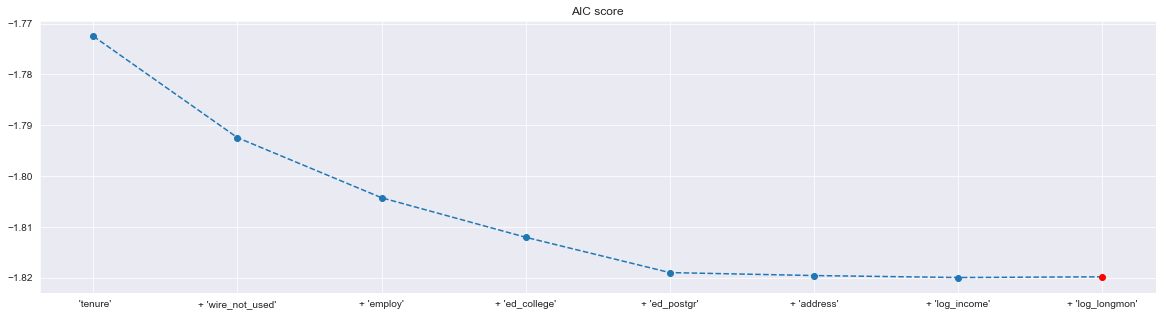

In [20]:
def AIC(y, y_hat, K):
    y = np.array(y).reshape(-1,1)
    y_hat = np.array(y_hat).reshape(-1,1)
    u = y - y_hat
    s2 = np.var(u, ddof=1)
    N = len(y)
    return np.log(s2) + 2 * K / N

def forward_selection(X, y, regressors, verbose=False, plot=True):
    regressors_selected, regressors_left = [], regressors.copy()
    scores_selected = []
    best_score = np.inf
    score = best_score
    while regressors_left != [] and score==best_score:
        regressor_score = []
        for regressor in regressors_left:
            X_selected = X.loc[:, regressors_selected+[regressor]]
            X_selected_ = sm.add_constant(X_selected)
            y_hat = sm.Logit(y, X_selected_).fit(disp=False).predict(X_selected_);
            s = AIC(y, y_hat, len(X_selected.columns))
            regressor_score.append(s)
            if verbose:
                print(regressors_selected+[regressor],': AIC = {:.3f}'.format(s))
        i = np.argmin(regressor_score)
        score = regressor_score[i]
        condition = (score < best_score)
        if condition:
            if verbose:
                print('> {} is chosen with score {}'.format(regressors_left[i], score))
            best_score = score 
            regressors_selected.append(regressors_left[i])
            scores_selected.append(score)
            del regressors_left[i]
    print('> In terms of {} ({} regressors):\n{}'.format('AIC', len(regressors_selected), regressors_selected))
    if plot:
        xs = regressors_selected+[regressors_left[i]]
        xs = ['{} \'{}\''.format('' if i==0 else '+', x) for i, x in enumerate(xs)]
        plt.plot(xs, scores_selected+[score], '--')
        plt.scatter(xs[:-1], scores_selected)
        plt.scatter(xs[-1], score, color='r', zorder=10)
        plt.title('{} score'.format('AIC'))
        plt.show()
    return regressors_selected


mpl.rcParams['figure.figsize'] = (20,5)
print('In total {} regressors: {}'.format(len(regressors), regressors))
print('\nThe best model (forward selection):')
regressors_selected = forward_selection(X, y, regressors)

In [21]:
X, y = get_X_y(df, regressand, regressors_selected)
K = X.shape[1]

X, _, X_intervals_means, X_intervals_stds, _, _ = \
                            get_normalized_X_y(X, y, regressors_selected)

X_ = sm.add_constant(X)
LogR = sm.Logit(y, X_).fit()
LogR.summary()

Explained: churn
Explanatory: ['tenure', 'wire_not_used', 'employ', 'ed_college', 'ed_postgr', 'address', 'log_income']
Optimization terminated successfully.
         Current function value: 0.482618
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  churn   No. Observations:                 1000
Model:                          Logit   Df Residuals:                      992
Method:                           MLE   Df Model:                            7
Date:                Tue, 07 May 2019   Pseudo R-squ.:                  0.1781
Time:                        12:00:04   Log-Likelihood:                -482.62
converged:                       True   LL-Null:                       -587.20
                                        LLR p-value:                 1.316e-41
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -1.3040      0.094    -13.934      0.000      -1.487      -1.121
tenure           -0.8193      0.106     -7.719      0.000      -1.027      -0.611
wire_not_used    -0.2426      0.080     -3.019      0.003      -0.400      -0.085
employ           -0.5032      0.151     -3.339      0.001      -0.799      -0.208
ed_college        0.1958      0.081      2.408      0.016       0.036       0.355
ed_postgr         0.1467      0.078      1.886      0.059      -0.006       0.299
address          -0.1850      0.113     -1.635      0.102      -0.407       0.037
log_income        0.2385      0.124      1.925      0.054      -0.004       0.481
=================================================================================
"""

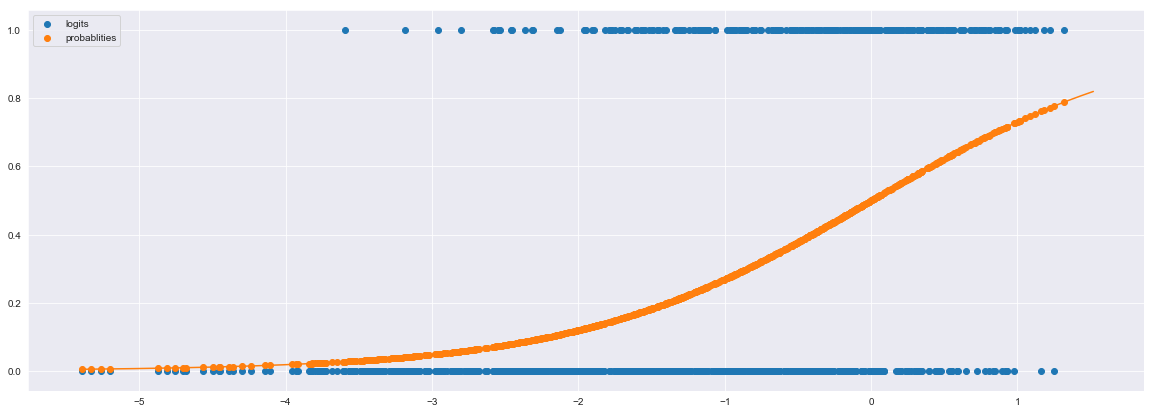

In [22]:
visualize_LogR(LogR, X_, y)

(d) Randomly pick up ﬁve clients. Determine their probabilities of leaving the company. Provide for the ﬁrst of them the formula which may be used to compute this probability with inserted values of parameters and variables. If you want to predict the membership in one of the two groups for a particular client, what is the simplest way to proceed using these probabilities?

In [23]:
np.random.seed(100)
clients_ids = np.random.choice(df.index, size=5, replace=False)
print('Clients ids:')
print(clients_ids)

print('\nProbablities of leaving the company:')
print(LogR.predict(X_.iloc[clients_ids]).values)

coefs = LogR.params
values = X_.iloc[clients_ids[0]]
logit = np.dot(coefs, values)
logit_str = ' + '.join(['{:.2f}*{:.2f}'\
                .format(x,v) for x,v in zip(coefs, values)])
eq_str = 'p(y=1) = g({})'.format(logit_str) + \
         ' = 1 / (1 + exp({:.2f}))'.format(-logit) + \
         ' = {:.3f}'.format(1/(1+np.exp(-logit)))

Clients ids:
[250 354 538 425 565]

Probablities of leaving the company:
[0.71386676 0.41572764 0.6741546  0.11481896 0.4469812 ]


> For the client $i$ the probability of leaving company (using logistic regression model) would be:
>
> \begin{equation}
p(y_i=1|x_i) = g\left(\beta^{\mathrm{T}} x_i\right)
\end{equation}
>where $g(\cdot)$ is the sigmoid function.
> For the first client we will have:

In [24]:
print(pd.concat([coefs, values], axis=1)\
.rename(columns={0:'Coefficient', 63:'Variable value'}))
print()
print(eq_str)

               Coefficient       251
const            -1.303997  1.000000
tenure           -0.819272 -1.569583
wire_not_used    -0.242643  0.648100
employ           -0.503195 -0.891383
ed_college        0.195829  1.808378
ed_postgr         0.146693 -0.265694
address          -0.185047 -0.252908
log_income        0.238468  1.170304

p(y=1) = g(-1.30*1.00 + -0.82*-1.57 + -0.24*0.65 + -0.50*-0.89 + 0.20*1.81 + 0.15*-0.27 + -0.19*-0.25 + 0.24*1.17) = 1 / (1 + exp(-0.91)) = 0.714


> The simplest way to predict the membership in one of the two groups using the probabilities is thresholding by $0.5$. So e.g. for the client above the probability is $0.714 > 0.5 \Rightarrow$ the client is in the group of those who may leave the company.

(e) Compute the classiﬁcation table and calculate the specifity and sensitivity. Provide verbal interpretation for the elements of the classiﬁcation table and the performance measures.

In [25]:
def report_classification(threshold=0.5, printout=True):
    classification_table = LogR.pred_table(threshold)
    if printout:
        print('Classification table')
        print('   0     1           (pred)')
        for i, row in enumerate(classification_table):
            print(i, row, row.sum())
        print(' ', *classification_table.sum(0))
        print('(true)')

        print()
        print('Specificity\tSensitivity')
        print('{:.4f}\t\t{:.4f}'.format(*np.diag(classification_table / classification_table.sum(1))))
    else:
        return tuple(np.diag(classification_table / classification_table.sum(1)))

report_classification(threshold=0.5)

Classification table
   0     1           (pred)
0 [669.  57.] 726.0
1 [173. 101.] 274.0
  842.0 158.0
(true)

Specificity	Sensitivity
0.9215		0.3686


> From the classification table we see that 37% (101/274) of clients that terminated the contract, were predicted correctly. This is the sensitivity. And the rest 63% (173/274) of clients were predicted wrongly (that they would stay). 92% (669 / 726) of clients that stayed with the company were correctly classified to it. This is the specificity. And only 8% of those were assigned to the wrong group.

(f) To improve the performance it makes sense to change the threshold used for classiﬁcation. This can be done using the ROC curve. Plot this curve and determine the optimal threshold.

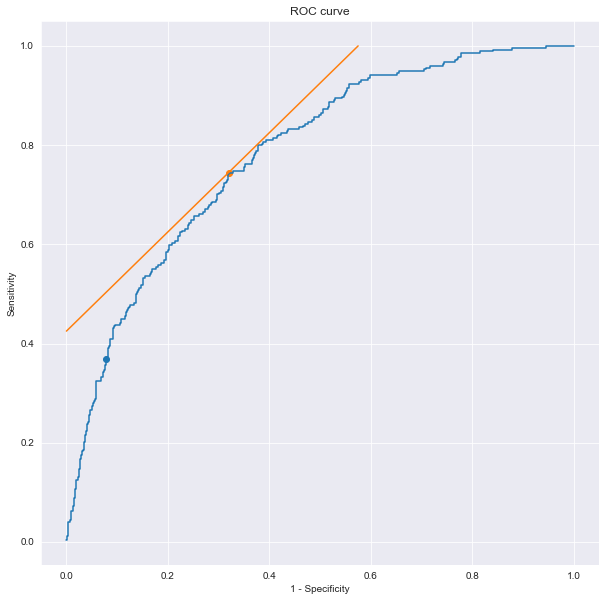

In [26]:
mpl.rcParams['figure.figsize'] = (10,10)
from sklearn.metrics import roc_curve
probs = LogR.predict(X_)
fpr, tpr, thresholds = roc_curve(y, probs)
plt.plot(fpr, tpr)
plt.ylabel('Sensitivity')
plt.xlabel('1 - Specificity')
specificity, sensitivity = report_classification(0.5, False)
plt.scatter(1-specificity, sensitivity)
specificity, sensitivity = report_classification(0.275, False)
plt.scatter(1-specificity, sensitivity, color='C1')
t = np.linspace(0,0.575,100)
plt.plot(t, t+0.425)
plt.title('ROC curve')
plt.show()

> From the ROC curve one may conclude that threshold $0.275$ is optimal if we need both high sensitivity and specificity.

(g) Recompute the classiﬁcation table, sensitivity and speciﬁty for the new threshold. Provide interpretation of the obtained values. Compare the results with the original values. Is the procedure now more strict/conservative?

In [27]:
report_classification(threshold=0.275)

Classification table
   0     1           (pred)
0 [493. 233.] 726.0
1 [ 70. 204.] 274.0
  563.0 437.0
(true)

Specificity	Sensitivity
0.6791		0.7445


> By relaxing the threshold from $0.5$ to $0.27$ we decreased the specificity from $0.922$ to $0.679$ (which means that the model is now less correct for negative examples), but increasedthe sensitivity $0.369$ to $0.745$ (which means that for positive examples the model now more often predicts correctly). Now the model is more conservative: it detects more clients that may leave the company.

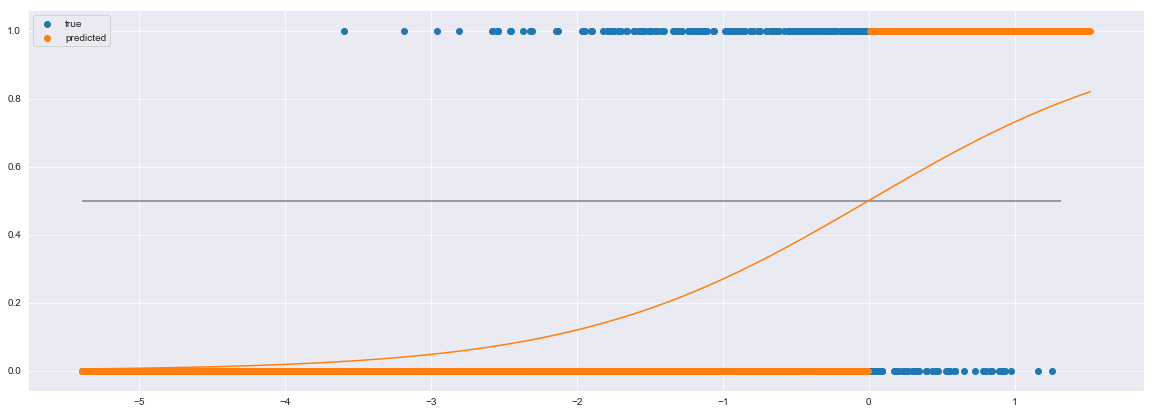

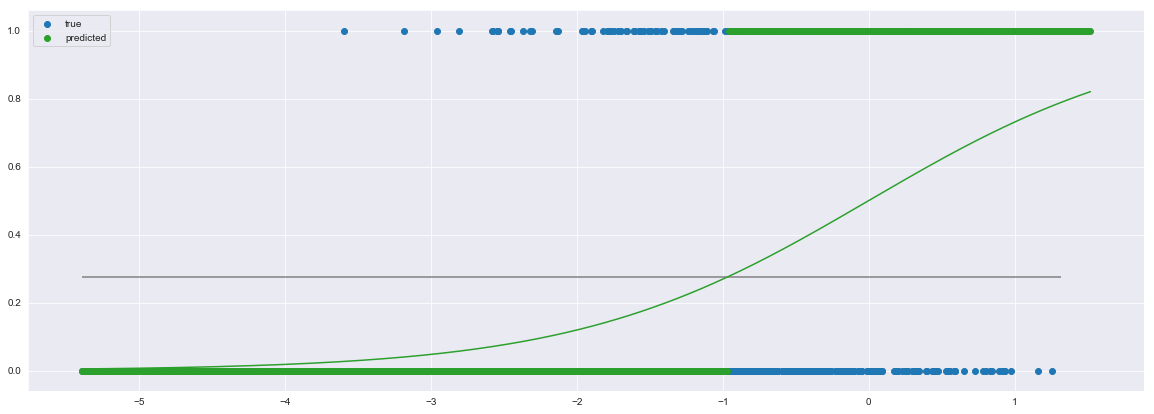

In [28]:
def visualize_LogR_threshold(LogR, X_, y, threshold=0.5, color='C1'):
    mpl.rcParams['figure.figsize'] = (20,7)
    logits = np.dot(X_, LogR.params)
    probs = LogR.predict(X_)
    t = np.linspace(logits.min(), logits.max()+0.2, 500)
    plt.scatter(logits, y, color='C0')
    plt.scatter(t, 1/(1 + np.exp(-t)) > threshold, color=color)
    plt.legend(['true', 'predicted'])
    plt.plot(t, 1/(1 + np.exp(-t)), color)
    plt.hlines(threshold, logits.min(), logits.max(), color='gray')
    plt.show()
    
visualize_LogR_threshold(LogR, X_, y, threshold=0.5, color='C1')
visualize_LogR_threshold(LogR, X_, y, threshold=0.275, color='C2')

### 5. In the next step we model longmon using regression trees.

(a) Assume the ﬁrst variable to be used for splitting is tenure. Write down the corresponding optimization problem and explain how the optimization works.

> We are at the first node which corresponds to a feature `tenure` and we want to find a threshold $t_1$. So at the first step the parameter is $\theta = \{t_1\}$. Let the data at current node be $Q$. The partitioning into $Q_{\text{left}}$ and $Q_{\text{right}}$ would be this:
>
> \begin{equation}
Q_{\text{left}}(\theta)=\{(x, y) \in Q ~|~ x_{\text{tenure}}<=t_1\}
\end{equation}
>
> \begin{equation}
Q_{\text{right}}(\theta)=\{(x, y) \in Q ~|~ x_{\text{tenure}}>t_1\} = Q ~\backslash~ Q_{\text{left}}(\theta)
\end{equation}
>
>The objective function is the impurity $G$:
>
>\begin{equation}
G(Q, \theta)=\frac{n_{\text{left}}}{N} H\left(Q_{\text{left}}(\theta)\right)+\frac{n_{\text{right}}}{N} H\left(Q_{\text{right}}(\theta)\right) \to \min_{\theta}
\end{equation}
>
>where $~H\left(Q\right)=\frac{1}{|N_Q|} \sum_{i \in N_Q}\left(y_{i}-\overline{y}\right)^2$,  $\quad\overline{y}=\frac{1}{|N_Q|} \sum_{i \in N_Q} y_{i}$
>
>At the node $k$ we will have the following split parameters $\theta = \{j_k, t_k\}$ where $j_k$ is a feature, $t_k$ is a threshold, and optimize the impurity by it: $\theta^{*}=\operatorname{argmin}_{\theta} G(Q, \theta)$
>
>By minimzing $G$ we are creating such split that has the smallest weighted (by proportions) sum of the sum-of-squares errors in left and right node data.

(b) Obviously you can get very long trees. Tree prunning helps to get trees of a reasonable size. Fit a CART to the data and prune it to have at most 10 splits. What is the value of the corresponding complexity parameter? Check you software for the implementation of the prunning, particularly the form of the loss function.

In [29]:
from sklearn.tree import DecisionTreeRegressor

regressand = 'longmon'
regressors = sorted(list(set(df.columns).difference(
    {'longmon','log_longmon', 'log_income', 'wire_not_used'})))

X, y = get_X_y(df, regressand, regressors)
K = X.shape[1]

clf = DecisionTreeRegressor(criterion='mse', splitter='best',
                            max_leaf_nodes=10)
clf = clf.fit(X, y)
y_pred = clf.predict(X)
print("R^2 for CART Regression: {:.3f}".format(r2_score(y, y_pred)))

Explained: longmon
Explanatory: ['address', 'age', 'churn', 'ed_college', 'ed_highschool', 'ed_postgr', 'ed_somecollege', 'employ', 'gender', 'income', 'marital', 'retire', 'tenure', 'wiremon']
R^2 for CART Regression: 0.769


> Here `max_leaf_nodes` parameter only manages the complexity, the regularization is not implemented.

(c) (*) Which properties of the trees guarantees that prunning using a single complexity parameter works? Give short verbal summary of these properties.

>The total cost of tree T consists of two components: resubstitution error $R(T)$, and a penalty for the complexity of the tree $\alpha|\tilde{T}|$.
>
>\begin{equation}
C_{\alpha}(T)=R(T)+\alpha|\tilde{T}|
\end{equation}
$\tilde{T}$ denotes the set of leaf nodes of $T$, $\alpha$ determines the complexity penalty.
>
>We denote the large tree that is to be pruned to the right size by $T_{\text {max}}$ . If we fix the value of  $\alpha$,  there is a smallest minimizing subtree $T(\alpha)$ of $T_{\text {max}}$ that fulfills the following conditions:
>
>\begin{equation}
\begin{array}{l}{\text { 1. } C_{\alpha}(T(\alpha))=\min _{T \leq T_{\max }} C_{\alpha}(T)} \\ {\text { 2. If } C_{\alpha}(T)=C_{\alpha}(T(\alpha)) \text { then } T(\alpha) \leq T}\end{array}
\end{equation}
>
>Minimizing subtree for any $\alpha$ always exists since there are only finitely many subtrees. Since there are at most a finite number of subtrees of $T_{max}$ , $C_{\alpha}(T)$ yields different values for only finitely many $\alpha$’s.